In [23]:
import numpy as np
import torch
import lightkurve as lk

print(f"NumPy: {np.__version__}")
print(f"PyTorch: {torch.__version__}")
print(f"Lightkurve: {lk.__version__}")
# print(f"CUDA available: {torch.cuda.is_available()}")

lc = lk.search_lightcurve("Kepler-10", author="Kepler", cadence="long")
print(f"Found {len(lc)} light curves for Kepler-10.")

NumPy: 2.4.1
PyTorch: 2.9.1+cpu
Lightkurve: 2.5.1
Found 15 light curves for Kepler-10.


In [24]:
import pandas as pd

url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+ps+where+disc_facility+like+'%25Kepler%25'+and+default_flag=1&format=csv"
planets_df = pd.read_csv(url)

print(f"Found {len(planets_df)} confirmed Kepler planets")

Found 2783 confirmed Kepler planets


C:\Users\mikem\AppData\Local\Temp\ipykernel_16628\3084108069.py:4: DtypeWarning: Columns (3,184) have mixed types. Specify dtype option on import or set low_memory=False.
  planets_df = pd.read_csv(url)


In [25]:
import lightkurve as lk
import os

# Create save directory (relative to notebook location)
SAVE_DIR = "../data/raw"
os.makedirs(SAVE_DIR, exist_ok=True)


def download_lightcurve(kepid):
    """Download and save a Kepler light curve."""
    
    filepath = f"{SAVE_DIR}/kic_{kepid}.fits"
    
    # Skip if already downloaded
    if os.path.exists(filepath):
        print(f"Already exists: {filepath}")
        return lk.read(filepath)
    
    # Search and download
    search = lk.search_lightcurve(f"KIC {kepid}", mission="Kepler", cadence="long")
    
    if len(search) == 0:
        print(f"Not found: KIC {kepid}")
        return None
    
    lc = search.download_all().stitch()
    lc.to_fits(filepath, overwrite=True)
    print(f"Saved: {filepath}")
    
    return lc


# Test
lc = download_lightcurve(11904151)  # Kepler-10
lc.plot()

Saved: ../data/raw/kic_11904151.fits


<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

In [26]:
# Sample Kepler IDs: confirmed planets
planet_kepids = [
    11904151,  # Kepler-10
    10797460,  # Kepler-22
    8191672,   # Kepler-16
    9941662,   # Kepler-36
    6922244,   # Kepler-62
]

# Download
for kepid in planet_kepids:
    download_lightcurve(kepid)
    print()

Already exists: ../data/raw/kic_11904151.fits



Saved: ../data/raw/kic_10797460.fits



Saved: ../data/raw/kic_8191672.fits



Saved: ../data/raw/kic_9941662.fits

Saved: ../data/raw/kic_6922244.fits



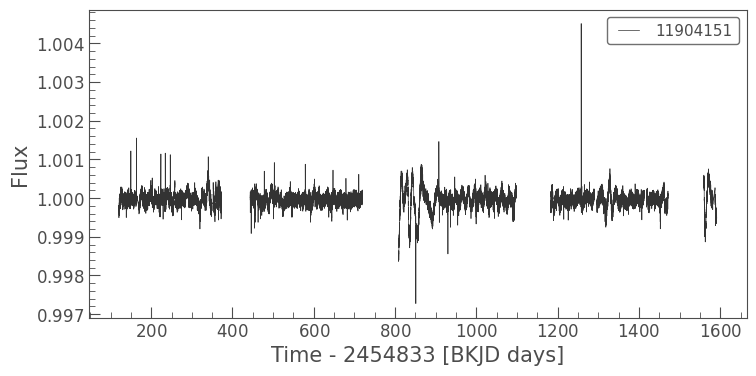

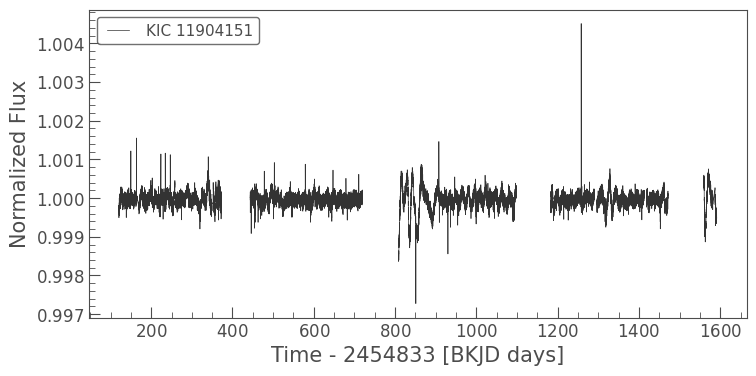

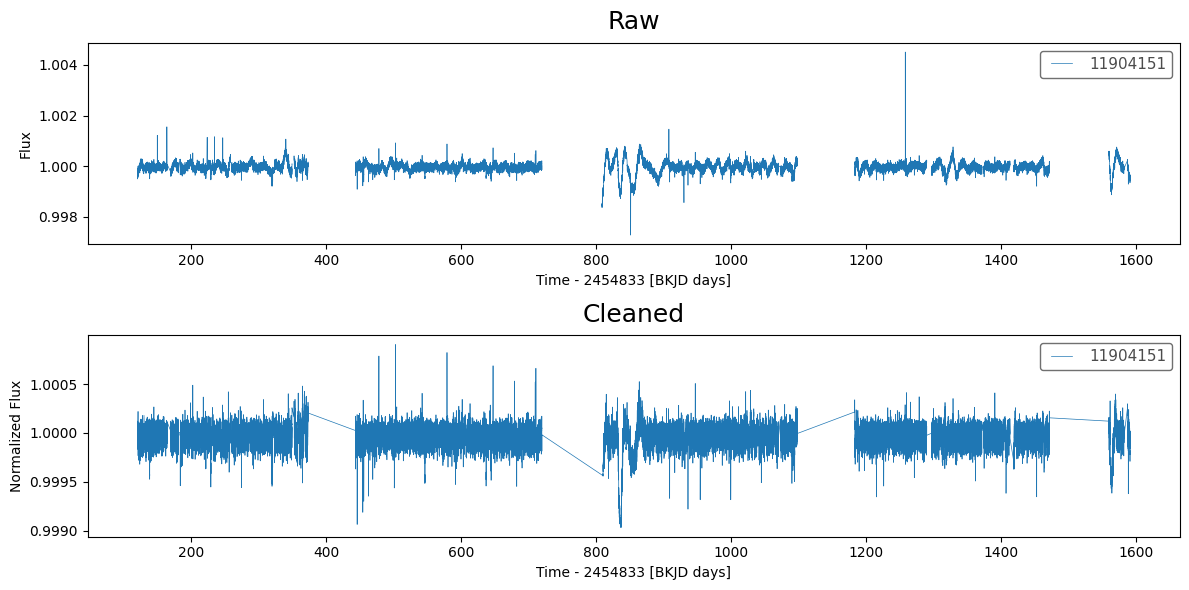

Points: 52195 → 51768


In [27]:
# Prepocessing one light curve
import matplotlib.pyplot as plt

# Load raw
lc_raw = lk.read("../data/raw/kic_11904151.fits")

# Clean
lc = lc_raw.remove_nans()
lc = lc.remove_outliers(sigma=5)
lc = lc.flatten(window_length=401)
lc = lc.normalize()

# Compare
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
lc_raw.plot(ax=axes[0], title="Raw")
lc.plot(ax=axes[1], title="Cleaned")
plt.tight_layout()
plt.show()

print(f"Points: {len(lc_raw)} → {len(lc)}")

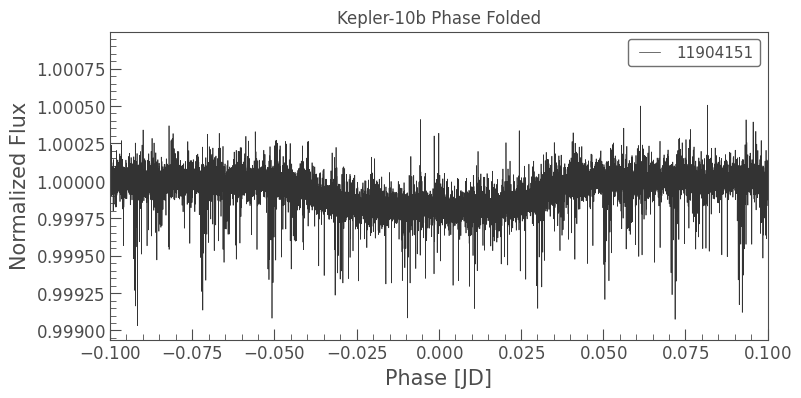

In [28]:
# Kepler-10b orbital period
period = 0.837495  # days
t0 = 131.57507    # first transit time (BKJD)

# Fold all transits onto each other
folded = lc.fold(period=period, epoch_time=t0)

# Plot
folded.plot()
plt.title("Kepler-10b Phase Folded")
plt.xlim(-0.1, 0.1)  # Zoom on transit
plt.show()

Shape: (2000,)
Mean: -0.0000, Std: 1.0000


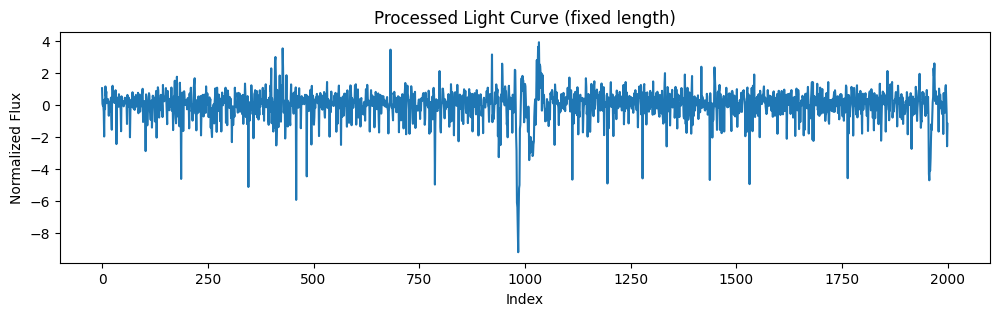

In [29]:
def process_lightcurve(filepath, period=None, t0=None, n_points=2000):
    """
    Load, clean, and convert light curve to fixed-length array.
    
    Parameters:
        filepath: Path to FITS file
        period: Orbital period (if known, will phase fold)
        t0: Epoch of first transit
        n_points: Output array length
    
    Returns:
        flux: numpy array of shape (n_points,)
    """
    
    # Load
    lc = lk.read(filepath)
    
    # Clean
    lc = lc.remove_nans()
    lc = lc.remove_outliers(sigma=5)
    lc = lc.flatten(window_length=401)
    lc = lc.normalize()
    
    # Phase fold if period known
    if period and t0:
        lc = lc.fold(period=period, epoch_time=t0)
    
    # Get flux values
    flux = lc.flux.value
    
    # Resample to fixed length
    from scipy.interpolate import interp1d
    x_old = np.linspace(0, 1, len(flux))
    x_new = np.linspace(0, 1, n_points)
    f = interp1d(x_old, flux, kind='linear', fill_value='extrapolate')
    flux_resampled = f(x_new)
    
    # Normalize to zero mean, unit variance
    flux_resampled = (flux_resampled - np.mean(flux_resampled)) / np.std(flux_resampled)
    
    return flux_resampled


# Test
flux = process_lightcurve("../data/raw/kic_11904151.fits")
print(f"Shape: {flux.shape}")
print(f"Mean: {flux.mean():.4f}, Std: {flux.std():.4f}")

plt.figure(figsize=(12, 3))
plt.plot(flux)
plt.title("Processed Light Curve (fixed length)")
plt.xlabel("Index")
plt.ylabel("Normalized Flux")
plt.show()

In [30]:
# More confirmed planets
planet_kepids = [
    11904151, 10797460, 8191672, 9941662, 6922244,   # Already have
    10593626, 3632418, 7040629, 8866102, 9002278,    # More planets
    5357901, 10874614, 6541920, 10227020, 5728139,
    7303287, 3861595, 9818381, 8684730, 10604335,
]

# False positives (eclipsing binaries) - these mimic transits
false_positive_kepids = [
    1026032, 1162635, 1432789, 1571511, 2162635,
    2302548, 2441495, 2576692, 2715264, 2849125,
    3098810, 3219434, 3339538, 3352358, 3453214,
    3558882, 3662635, 3735712, 3836439, 3935914,
]

print("Downloading planets...")
for kepid in planet_kepids:
    download_lightcurve(kepid)

print("\nDownloading false positives...")
for kepid in false_positive_kepids:
    download_lightcurve(kepid)

Already exists: ../data/raw/kic_11904151.fits
Already exists: ../data/raw/kic_10797460.fits
Already exists: ../data/raw/kic_8191672.fits
Already exists: ../data/raw/kic_9941662.fits
Already exists: ../data/raw/kic_6922244.fits


Saved: ../data/raw/kic_10593626.fits


Saved: ../data/raw/kic_3632418.fits


Saved: ../data/raw/kic_7040629.fits


Saved: ../data/raw/kic_8866102.fits


Saved: ../data/raw/kic_9002278.fits


Saved: ../data/raw/kic_5357901.fits


Saved: ../data/raw/kic_10874614.fits


Saved: ../data/raw/kic_6541920.fits


Saved: ../data/raw/kic_10227020.fits


Saved: ../data/raw/kic_5728139.fits


Saved: ../data/raw/kic_7303287.fits


Saved: ../data/raw/kic_3861595.fits


Saved: ../data/raw/kic_9818381.fits


Saved: ../data/raw/kic_8684730.fits


Saved: ../data/raw/kic_10604335.fits



Saved: ../data/raw/kic_1026032.fits


Saved: ../data/raw/kic_1162635.fits


Saved: ../data/raw/kic_1432789.fits


Saved: ../data/raw/kic_1571511.fits


Saved: ../data/raw/kic_2162635.fits


Saved: ../data/raw/kic_2302548.fits


Saved: ../data/raw/kic_2441495.fits


Saved: ../data/raw/kic_2576692.fits


Could not resolve "KIC 2715264" to a sky position.


Not found: KIC 2715264


Saved: ../data/raw/kic_2849125.fits


Saved: ../data/raw/kic_3098810.fits


Could not resolve "KIC 3219434" to a sky position.


Not found: KIC 3219434


Saved: ../data/raw/kic_3339538.fits


Could not resolve "KIC 3352358" to a sky position.


Not found: KIC 3352358


Saved: ../data/raw/kic_3453214.fits


Could not resolve "KIC 3558882" to a sky position.


Not found: KIC 3558882


Saved: ../data/raw/kic_3662635.fits


Could not resolve "KIC 3735712" to a sky position.


Not found: KIC 3735712


Saved: ../data/raw/kic_3836439.fits
Saved: ../data/raw/kic_3935914.fits


In [31]:
import os
import numpy as np

def build_dataset(planet_kepids, fp_kepids, n_points=2000):
    """
    Create X (features) and y (labels) arrays.
    
    Labels: 1 = planet, 0 = not planet
    """
    
    X = []
    y = []
    kepids = []
    
    # Process planets (label = 1)
    for kepid in planet_kepids:
        filepath = f"../data/raw/kic_{kepid}.fits"
        if not os.path.exists(filepath):
            continue
        
        try:
            flux = process_lightcurve(filepath, n_points=n_points)
            X.append(flux)
            y.append(1)
            kepids.append(kepid)
        except Exception as e:
            print(f"Error processing {kepid}: {e}")
    
    # Process false positives (label = 0)
    for kepid in fp_kepids:
        filepath = f"../data/raw/kic_{kepid}.fits"
        if not os.path.exists(filepath):
            continue
        
        try:
            flux = process_lightcurve(filepath, n_points=n_points)
            X.append(flux)
            y.append(0)
            kepids.append(kepid)
        except Exception as e:
            print(f"Error processing {kepid}: {e}")
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y, kepids


# Build dataset
X, y, kepids = build_dataset(planet_kepids, false_positive_kepids)

print(f"Dataset shape: {X.shape}")
print(f"Labels: {len(y[y==1])} planets, {len(y[y==0])} non-planets")

# Save for later
np.save("../data/processed/X.npy", X)
np.save("../data/processed/y.npy", y)
print("Saved to data/processed/")

Dataset shape: (35, 2000)
Labels: 20 planets, 15 non-planets
Saved to data/processed/


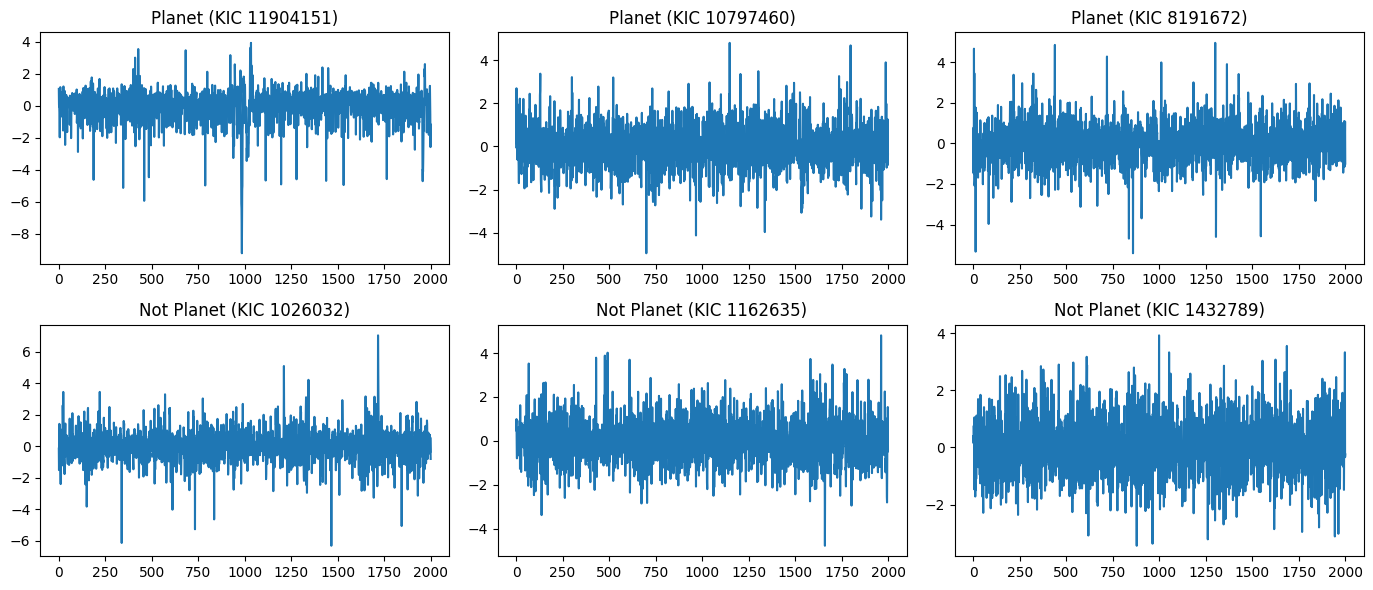

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(14, 6))

# Plot 3 planets
planet_idx = np.where(y == 1)[0][:3]
for i, idx in enumerate(planet_idx):
    axes[0, i].plot(X[idx])
    axes[0, i].set_title(f"Planet (KIC {kepids[idx]})")

# Plot 3 non-planets
fp_idx = np.where(y == 0)[0][:3]
for i, idx in enumerate(fp_idx):
    axes[1, i].plot(X[idx])
    axes[1, i].set_title(f"Not Planet (KIC {kepids[idx]})")

plt.tight_layout()
plt.show()

In [44]:
# Old API endpoint
url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI"
params = "table=q1_q17_dr25_tce&select=kepid,tce_period,tce_depth,tce_duration,av_training_set&format=csv"

df = pd.read_csv(f"{url}?{params}")
print(f"Rows: {len(df)}")
print(df.head())

Rows: 34032
     kepid  tce_period  tce_depth  tce_duration  av_training_set
0  2304168  431.719000    488.400        13.220              NaN
1  2304235    0.570607     75.150         1.160              NaN
2  2304566    0.689480      3.794         5.236              NaN
3  2304320   16.540800    366.700         2.715              NaN
4  2303365    0.520697    123.600         1.035              NaN


In [45]:
import pandas as pd

# Get confirmed planets
url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI"
params = "table=cumulative&select=kepid,koi_period,koi_depth,koi_duration,koi_disposition&format=csv"

df = pd.read_csv(f"{url}?{params}")
print(f"Rows: {len(df)}")
print(df['koi_disposition'].value_counts())
print(df.head())

Rows: 9564
koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64
      kepid  koi_period  koi_depth  koi_duration koi_disposition
0  10797460    9.488036      615.8       2.95750       CONFIRMED
1  10797460   54.418383      874.8       4.50700       CONFIRMED
2  10811496   19.899140    10829.0       1.78220       CANDIDATE
3  10848459    1.736952     8079.2       2.40641  FALSE POSITIVE
4  10854555    2.525592      603.3       1.65450       CONFIRMED


In [46]:
# Create labels: 1 = confirmed planet, 0 = false positive
# Drop candidates (uncertain)
df_labeled = df[df['koi_disposition'] != 'CANDIDATE'].copy()
df_labeled['label'] = (df_labeled['koi_disposition'] == 'CONFIRMED').astype(int)

# Features
feature_cols = ['koi_period', 'koi_depth', 'koi_duration']
df_labeled = df_labeled.dropna(subset=feature_cols)

X = df_labeled[feature_cols].values
y = df_labeled['label'].values

print(f"X shape: {X.shape}")
print(f"Planets: {sum(y==1)}, False positives: {sum(y==0)}")

X shape: (7326, 3)
Planets: 2744, False positives: 4582


In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")

Train: 5860, Test: 1466


In [48]:
import os

os.makedirs("../data/processed", exist_ok=True)
np.save("../data/processed/X_train.npy", X_train)
np.save("../data/processed/X_test.npy", X_test)
np.save("../data/processed/y_train.npy", y_train)
np.save("../data/processed/y_test.npy", y_test)

print("Saved.")

Saved.


In [49]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Dataset class
class ExoplanetDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataloaders
train_dataset = ExoplanetDataset(X_train, y_train)
test_dataset = ExoplanetDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 184
Test batches: 46


In [50]:
class ExoplanetNN(nn.Module):
    def __init__(self, input_size=3):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.network(x).squeeze()

model = ExoplanetNN()
print(model)

ExoplanetNN(
  (network): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [51]:
# Setup
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        # Forward
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Print every 10 epochs
    if (epoch + 1) % 10 == 0:
        train_loss /= len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}")

print("Training complete.")

Epoch 10/50, Loss: 0.4367
Epoch 20/50, Loss: 0.4046
Epoch 30/50, Loss: 0.3943
Epoch 40/50, Loss: 0.3900
Epoch 50/50, Loss: 0.3820
Training complete.


In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Evaluate
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.numpy())
        all_labels.extend(y_batch.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Metrics
print(f"Accuracy:  {accuracy_score(all_labels, all_preds):.4f}")
print(f"Precision: {precision_score(all_labels, all_preds):.4f}")
print(f"Recall:    {recall_score(all_labels, all_preds):.4f}")
print(f"F1 Score:  {f1_score(all_labels, all_preds):.4f}")

print(f"\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

Accuracy:  0.8076
Precision: 0.7251
Recall:    0.7832
F1 Score:  0.7531

Confusion Matrix:
[[754 163]
 [119 430]]


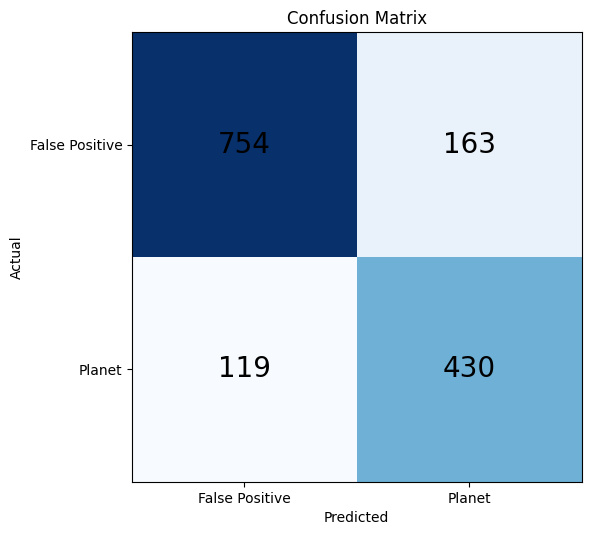

In [53]:
import matplotlib.pyplot as plt

# Confusion matrix plot
cm = confusion_matrix(all_labels, all_preds)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, cmap='Blues')

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['False Positive', 'Planet'])
ax.set_yticklabels(['False Positive', 'Planet'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

# Add numbers
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', fontsize=20)

plt.tight_layout()
plt.show()

In [54]:
# Save model
os.makedirs("../models", exist_ok=True)
torch.save(model.state_dict(), "../models/exoplanet_nn.pt")
print("Model saved.")

Model saved.
